## Based on the followings:
* http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
* http://adventuresinmachinelearning.com/keras-lstm-tutorial/
* https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/
* https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://github.com/farizrahman4u/seq2seq
* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## TODO
* ~~look into categorical representation~~
* ~~look into the number of missing words over the total~~
* ~~look into different models (attention, hierachical, etc.)~~
* compute BLEU on test set

In [31]:
import os
import re
import numpy as np
import glob
import pickle as pkl
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time

from string import punctuation
from itertools import islice
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Layer, Input, LSTM, GRU, Dense, Masking, Embedding, Activation
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

from sklearn.model_selection import KFold

In [2]:
DATA_PATH = 'data'
OUTPUT_PATH = 'output'
punct = set(punctuation)
file_list = sorted(glob.glob('data/parsed/*.txt'))

In [6]:
w2v = KeyedVectors.load_word2vec_format(os.path.join(DATA_PATH, 'GoogleNews-vectors-negative300.bin.gz'), binary=True)

In [3]:
# re-load params
with open(os.path.join(DATA_PATH, 'data_20k.pkl'), 'rb') as data_file, open(os.path.join(DATA_PATH, 'params_20k.pkl'), 'rb') as params_file:
    data = pkl.load(data_file)
    params = pkl.load(params_file)
    tokenizer = params['tokenizer']
    index_word = params['index_word']
    word2embeddings = params['w2e']
    embedding_matrix = params['W']
    missing_words = params['missing_words']

In [4]:
embedding_dim = 300#w2v.vector_size
eos_token = 'EOS'
unk_token = 'UNK'
eos_vector = np.ones((embedding_dim))
unk_vector = np.zeros((embedding_dim))

In [5]:
def preprocess(text):
    text = re.sub(repl='', string=text, pattern='^> ') # remove starting caret, if any
    text = re.sub(repl='\g<1> \g<2>', string=text, pattern='(\w+)-(\w+)') # compound words    
    text = re.sub(repl=' ', string=text, pattern='-{2,}|\s{2,}|[%s\t\n/]' % (''.join(punctuation)))
#     text = re.sub(repl=' digits ', string=text, pattern='^\d+$| \d+| \d+ ') # replace digits with a standard 'digits' word
    return text

def read_corpus(file_list):
    corpus = []
    for file in file_list:
        with open(file, 'r', encoding='utf-8') as f:
            print('read_corpus: processing [{}]'.format(file))
            corpus.append(f.read())
            
    return corpus
            
def build_vocabulary(corpus, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words+1, oov_token=oov_token) # +1 for the oov token
    tokenizer.fit_on_texts(corpus)
    
    # Fix keras' nasty behaviour. See https://github.com/keras-team/keras/issues/8092
    # Only include words found in w2v
    tokenizer.word_index = {w:i for  w,i in tokenizer.word_index.items() 
                                if   i <= num_words} # <= because tokenizer is 1 indexed (this will leave out UNK)
    tokenizer.num_words = num_words + 2  # UNK + EOS
    tokenizer.word_index[oov_token] = len(tokenizer.word_index) + 1
    tokenizer.word_index[eos_token] = len(tokenizer.word_index) + 1
    index_word = [None for i in range(len(tokenizer.word_index) + 1)]  # index is 1-based
    for w,i in tokenizer.word_index.items():
        index_word[i] = w
    
    return tokenizer, index_word

def prepare_data(corpus, tokenizer):
    # Still go through the files line by line, as we want to predict the next scene, 
    # not just the next sentence
    data = []
    for i, doc in enumerate(corpus):
        doc_data = []
        print('prepare_data: processing [{}]'.format(file_list[i]))
        
        for j, line in enumerate(doc.split('\n')):
            if len(line) == 0:
                print('Line {} is empty. Replacing with "empty line".'.format(j+1))
                line = 'empty line'

            doc_data.append(tokenizer.texts_to_sequences([line])[0])

        if len(doc_data) == 0:
            print('File {} has no data'.format(file_list[i]))
        else:
            data.append(doc_data)
        
    return data

def get_embeddings(word_index, w2v, unk_vector):
    embedding_matrix=np.zeros(shape=(len(word_index)+2, w2v.vector_size))  # +2 as keras' tokenizer is 1-based
    missing_words = []
    for word,i in word_index.items():
        if word not in w2v:
            # Try to capitalize it
            if word.capitalize() not in w2v:
                missing_words.append(word)
                embedding_matrix[i] = unk_vector
            else:
                embedding_matrix[i] = w2v[word.capitalize()]
        else:
            embedding_matrix[i] = w2v[word]
    
    # add EOS token
    embedding_matrix[-1] = eos_vector # keras' index the vocab starting from 1
    embedding_matrix[-2] = unk_vector
    return embedding_matrix, missing_words

def get_embedding_matrix(word2embeddings):
    embedding_dim = len(list(word2embeddings.values())[0])
    embedding_matrix = np.zeros(shape=(len(word2embeddings)+2, embedding_dim)) # +2 as keras tokenizer is 1-based
    for i, w in enumerate(word2embeddings): # keras' tokenizer index is 1-based
        embedding_matrix[i+1] = word2embeddings[w]
    
    return embedding_matrix

In [41]:
corpus = read_corpus(file_list)
tokenizer, index_word = build_vocabulary(corpus, num_words=20000, oov_token=unk_token)
embedding_matrix, missing_words = get_embeddings(tokenizer.word_index, w2v, unk_vector)

read_corpus: processing [data/parsed/parsed-12heads.txt]
read_corpus: processing [data/parsed/parsed-1893.txt]
read_corpus: processing [data/parsed/parsed-20160221-thesueno-utf8.txt]
read_corpus: processing [data/parsed/parsed-20160221-thesueno.txt]
read_corpus: processing [data/parsed/parsed-3card-deadmanshill-2016Ap24.txt]
read_corpus: processing [data/parsed/parsed-69krakatoa.txt]
read_corpus: processing [data/parsed/parsed-905-shrapnel.txt]
read_corpus: processing [data/parsed/parsed-abno.txt]
read_corpus: processing [data/parsed/parsed-acg-crossbow.txt]
read_corpus: processing [data/parsed/parsed-acitw.txt]
read_corpus: processing [data/parsed/parsed-actofmurder.txt]
read_corpus: processing [data/parsed/parsed-adverbum.txt]
read_corpus: processing [data/parsed/parsed-afdfr.txt]
read_corpus: processing [data/parsed/parsed-afflicted.txt]
read_corpus: processing [data/parsed/parsed-allthingsdevours.txt]
read_corpus: processing [data/parsed/parsed-aotearoa.txt]
read_corpus: processing

NameError: name 'w2v' is not defined

In [6]:
print('Vocabulary size:', tokenizer.num_words)
print('OOV token index:', tokenizer.word_index[unk_token])
print('EOS token index:', tokenizer.word_index[eos_token])

Vocabulary size: 20002
OOV token index: 20001
EOS token index: 20002


In [7]:
# text = 'Sample sentence with a possible balabiut token and some 1984 plus sentry'
# print(preprocess(text))
# print(prepare_input(text, tokenizer))
vocab_size = len(embedding_matrix)
unk_index = tokenizer.word_index[unk_token]
eos_index = unk_index+1
print('Embedding matrix size:', embedding_matrix.shape)
print('Total triples:', sum([(len(f)-3)//2 for f in data]))
print('Unique words found (UNK, EOS + vocab):', len(tokenizer.word_index))
print('Of which missing words (no embeddings):', len(missing_words))

Embedding matrix size: (20003, 300)
Total triples: 131807
Unique words found (UNK, EOS + vocab): 20002
Of which missing words (no embeddings): 1557


In [9]:
data = prepare_data(corpus, tokenizer)

prepare_data: processing [data/parsed/parsed-12heads.txt]
prepare_data: processing [data/parsed/parsed-1893.txt]
Line 1197 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-20160221-thesueno-utf8.txt]
prepare_data: processing [data/parsed/parsed-20160221-thesueno.txt]
Line 1445 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-3card-deadmanshill-2016Ap24.txt]
prepare_data: processing [data/parsed/parsed-69krakatoa.txt]
prepare_data: processing [data/parsed/parsed-905-shrapnel.txt]
prepare_data: processing [data/parsed/parsed-abno.txt]
Line 1217 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-acg-crossbow.txt]
Line 1825 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-acitw.txt]
prepare_data: processing [data/parsed/parsed-actofmurder.txt]
Line 567 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-adverbum.txt]
Line 

prepare_data: processing [data/parsed/parsed-invisargo.txt]
Line 89 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-jabberwocky.txt]
prepare_data: processing [data/parsed/parsed-jacket4.txt]
prepare_data: processing [data/parsed/parsed-jacqissick.txt]
prepare_data: processing [data/parsed/parsed-jfw.txt]
Line 27 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-ka.txt]
prepare_data: processing [data/parsed/parsed-laidoff-1May2016.txt]
prepare_data: processing [data/parsed/parsed-laidoff-subrosa-1May2016.txt]
Line 539 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-lethe.txt]
prepare_data: processing [data/parsed/parsed-littlebluemen.txt]
prepare_data: processing [data/parsed/parsed-lmwh.txt]
prepare_data: processing [data/parsed/parsed-loose.txt]
Line 675 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-lostpig.txt]
prepare_data: processing [data/

prepare_data: processing [data/parsed/parsed-turkeyspeeds.txt]
Line 1271 is empty. Replacing with "empty line".
Line 1575 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-unclezeb.txt]
prepare_data: processing [data/parsed/parsed-undertow.txt]
prepare_data: processing [data/parsed/parsed-unipool.txt]
prepare_data: processing [data/parsed/parsed-unscientific.txt]
Line 4597 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-vagueness.txt]
prepare_data: processing [data/parsed/parsed-varkana.txt]
prepare_data: processing [data/parsed/parsed-violet.txt]
prepare_data: processing [data/parsed/parsed-wand.txt]
prepare_data: processing [data/parsed/parsed-weapon.txt]
prepare_data: processing [data/parsed/parsed-wedding.txt]
Line 4547 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-windjack.txt]
prepare_data: processing [data/parsed/parsed-winterwonderland.txt]
prepare_data: processing [data/

In [46]:
# save various objects for later reuse
with open(os.path.join(DATA_PATH, 'data_20k.pkl'), 'wb') as data_file, open(os.path.join(DATA_PATH, 'params_20k.pkl'), 'wb') as params_file:
    params = {
        'tokenizer': tokenizer,
        'index_word': index_word,
        'W': embedding_matrix,
        'w2e': word2embeddings,
        'missing_words': missing_words
    }
    pkl.dump(data, data_file)
    pkl.dump(params, params_file)
    

In [8]:
def window(seq, n=3, step=1):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s[0],...s[n-1]), (s[0+skip_n],...,s[n-1+skip_n]), ...   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    

    result = result[step:]
    for elem in it:
        result = result + (elem,)
        if len(result) == n:
            yield result
            result = result[step:]

def create_samples(data, test_split=0.1, shuffle=False, max_seq_length=None):    
    samples = []
    for i, play in enumerate(data):
        if max_seq_length is not None:
            chunks = [line[offset:offset+max_seq_length] 
                      for line in play 
                      for offset in range(0, len(line), max_seq_length)]
        else:
            chunks = play
            
        for scene, command, reply in window(chunks, n=3, step=2):
#             if max_seq_length is not None:
#                 sub_scenes  = [scene[offset:offset+max_seq_length]   for offset in range(0, len(scene),   max_seq_length)]
#                 sub_cmds    = [command[offset:offset+max_seq_length] for offset in range(0, len(command), max_seq_length)]
#                 sub_replies = [reply[offset:offset+max_seq_length]   for offset in range(0, len(reply),   max_seq_length)]
                
#                 nb_samples = 
#                 # sample a number of contextual sequences
#                 scenes   = sub_scenes[np.random.choice(range(len(sub_scenes)), len(sub_scenes)//max_seq_length)]
#                 commands = sub_cmds[np.random.choice(range(len(sub_cmds)), len(sub_cmds)//max_seq_length)]
#                 replies   = sub_replies[np.random.choice(range(len(sub_replies)), len(sub_replies)//max_seq_length)]
                
                
#             if len(command) > 10:
#                 command_line = ' '.join([index_word[idx] for idx in command])
#                 print('Found anomalous command for play {} [{}] with length {}: [{}]'.format(
#                     i, os.path.basename(file_list[i]), len(command), command_line))
                
            samples.append((scene, command, reply))
    
    if shuffle:
        np.random.shuffle(samples)
        
    if test_split is not None:
        split = int((1-test_split) * len(samples))
        train_samples = samples[:split]
        test_samples = samples[split:]
        return train_samples, test_samples
    
    return samples

In [9]:
# Define a batch generator
class BatchGenerator(object):
    def __init__(self, data, vocab_size, batch_size=1, reverse_input=True, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocab_size = vocab_size
        self.reverse_input = reverse_input
        self.UNK = unk_index
        self.EOS = eos_index
        self.PAD = 0
        
    def generate_batch(self): 
        # every three lines comprise a sample sequence where the first two items
        # are the input and the last one is the output
        i  = 1 # batch counter        
        x_enc = []
        x_dec = []
        y  = []
            
        while True:
            if self.shuffle:
                np.random.shuffle(self.data)
            
            for j, (scene, command, reply) in enumerate(self.data):
                if self.reverse_input:
                    scene = scene[::-1]
                    
                encoder_input  = np.array(scene + command)
                decoder_input  = np.array([self.EOS] + reply)
                decoder_output = np.array(to_categorical(reply + [self.EOS], self.vocab_size))
                    
                x_enc.append(encoder_input)
                x_dec.append(decoder_input)
                y.append(decoder_output)
                
                if i == self.batch_size or j == len(data):
                    if self.batch_size > 1:
                        # pad and return the batch
                        x_enc = sequence.pad_sequences(x_enc, padding='post', value=self.PAD)
                        x_dec = sequence.pad_sequences(x_dec, padding='post', value=self.PAD)    
                        y     = sequence.pad_sequences(y, padding='post', value=self.PAD)

                    x_out, y_out = [np.array(x_enc), np.array(x_dec)], np.array(y)
                    
                    i = 1
                    x_enc = []
                    x_dec = []
                    y = []

                    yield (x_out, y_out)
                else:
                    i += 1 # next sample per batch

In [10]:
# returns train, inference_encoder and inference_decoder models
def define_models_lstm(src_vocab_size, embedding_matrix, dst_vocab_size=None, embedding_dim=300, latent_dim=128, 
                       mask_value=0, trainable_embeddings=False, encoder_depth=1, decoder_depth=1):
    # define training encoder. We use return_state to retrieve the hidden states for the encoder and
    # provide them as input to the decoder
    if dst_vocab_size is None:
        dst_vocab_size = src_vocab_size
        
    encoder_inputs = Input(shape=(None,)) # timesteps, features (integer)
    decoder_inputs = Input(shape=(None,))
    inputs = [encoder_inputs, decoder_inputs]
    
    encoder_masking = Masking(mask_value=mask_value)(encoder_inputs)
    decoder_masking = Masking(mask_value=mask_value)(decoder_inputs)
    
    encoder_embedding = Embedding(input_dim=src_vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                               trainable=trainable_embeddings)(encoder_masking)
    decoder_embedding = Embedding(input_dim=src_vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                               trainable=trainable_embeddings)(decoder_masking)
    
    ######## ENCODER ########
    encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    for _ in range(encoder_depth-1):  # DEPTH (the encoder need not be shared, so we can just instantiate a new LSTM object)
        encoder_outputs, state_h, state_c = LSTM(units=latent_dim, return_sequences=True, return_state=True)(encoder_outputs)
        encoder_states = [state_h, state_c]
    
    ######## DECODER ########
    decoder_layers = []  # keep track of deep layers
    
    # define training decoder. It is initialized with the encoder hidden states
    decoder_lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    for _ in range(decoder_depth-1):  # DEPTH
        lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True)
        decoder_layers.append(lstm)
        decoder_outputs, _, _ = lstm(decoder_outputs)
        
    decoder_dense = Dense(dst_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
        
    model = Model(inputs, decoder_outputs)
    
    ####### INFERENCE ENCODER #######
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    ####### INFERENCE DECODER #######
    # define inference decoder
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]    
    for d in range(decoder_depth - 1):  # DEPTH
        decoder_outputs, state_h, state_c = decoder_layers[d](decoder_outputs)
        decoder_states = [state_h, state_c]
    
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model

In [33]:
def plot_loss(loss, val_loss, color=None, fname=None, legend=False):
        N = len(loss)
        train_loss_plt, = plt.plot(range(0, N), loss)
        val_loss_plt, = plt.plot(range(0, N), val_loss)
        
        if color is not None:
            plt.setp(train_loss_plt, color=color, linestyle='-')
            plt.setp(val_loss_plt, color=color, linestyle='--')
            
        if legend:
            plt.legend((train_loss_plt, val_loss_plt), ('train loss', 'val loss'))
        
        if fname is not None:
            plt.savefig(fname)
        
        return [train_loss_plt, val_loss_plt]

def plot(losses, fname=None):        
    lines = []
    names = []
    colors = [plt.cm.gist_ncar(i) for i in np.linspace(0, 1, len(losses))]
    for i, (loss, val_loss) in enumerate(losses):
        lines.extend(plot_loss(loss, val_loss, colors[i]))
        names.extend(['{} loss'.format(i+1), '{} val loss'.format(i+1)])
    
    plt.legend(lines, names)
    
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()

In [48]:
from sklearn.model_selection import train_test_split

class InferenceModelsCheckpoint(Callback):
    def __init__(self, models, filepath, monitor='val_loss', verbose=0):
        self.encoder, self.decoder = models
        self.monitor = monitor
        self.filepath = filepath
        self.verbose = verbose
        self.best = np.Inf
        
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current < self.best:
            filepath = self.filepath
            if self.verbose > 0:
                print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                
            self.encoder.save(filepath + '-encinf.h5')
            self.decoder.save(filepath + '-decinf.h5')                
            self.best = current

def train_model(models, train_samples, batch_size, epochs=10, shuffle=True, n_folds=None, train_split=None, model_name=None):
    assert not (n_folds is not None and train_split is not None), ValueError('Either n_folds or train_split should be specified, but not both.')
    assert not (n_folds is None and train_split is None), ValueError('Either n_folds or train_split must be specified.')   
    
    def _run_model(train, val):
        train_generator = BatchGenerator(train, batch_size=batch_size, vocab_size=vocab_size, reverse_input=True, shuffle=shuffle)
        val_generator = BatchGenerator(val, batch_size=batch_size, vocab_size=vocab_size, reverse_input=True, shuffle=shuffle)
        
        # utils callbacks
        checkpointer = ModelCheckpoint(filepath=model_name + '.h5', verbose=1, save_best_only=True)
        seq2seq_cp = InferenceModelsCheckpoint(filepath=model_name, verbose=1, models=(encoder, decoder))
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', 
                                      min_delta=0.0001, cooldown=0, min_lr=0)
        early_stop = EarlyStopping(patience=1, min_delta=0.0001, verbose=1)
        callbacks = [checkpointer, seq2seq_cp, reduce_lr, early_stop]
        
        # actual train
        history = model.fit_generator(train_generator.generate_batch(), steps_per_epoch=len(train)//batch_size, epochs=epochs, 
                            validation_data=val_generator.generate_batch(), validation_steps=len(val)//batch_size,
                            callbacks=callbacks)
        
        return history
        
    model, encoder, decoder = models
    train_samples = np.array(train_samples)
    losses = []  # keep track of train and val loss for each fold
    
    if n_folds is None:
        train, val = train_test_split(train_samples, train_size=train_split, shuffle=shuffle)
        
        history = _run_model(train, val)
        # plot current losses
        plot_loss(history.history['loss'], history.history['val_loss'], fname=model_name + '.png')
    else:  
        kfold = KFold(n_folds, shuffle=shuffle)
        for i, (train, val) in enumerate(kfold.split(train_samples)):
            print("Running fold {}/{}".format(i+1, n_folds))

            model_file = model_name + '-fold-{}'.format(i+1)
            history = _run_model(train_samples[train], train_samples[val])

            # record losses for the final plot
            losses.append((history.history['loss'], history.history['val_loss']))

        # plot losses for all folds
        plot(losses, model_name + '.png')

In [49]:
model_name = 'basic_seq2seq_20k_200_300d_1-1_LSTM'
# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

In [50]:
train_samples, test_samples = create_samples(data, max_seq_length=200, test_split=0.01)
print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Train samples: 132060
Test samples: 1334


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
3920/3920 [==============================] - 6104s 2s/step - loss: 0.8654 - categorical_accuracy: 0.0328 - val_loss: 0.8131 - val_categorical_accuracy: 0.0424

Epoch 00001: val_loss improved from inf to 0.81312, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_11/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'lstm_11/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '



Epoch 00001: saving model to basic_seq2seq_20k_200_300d_1-1_LSTM


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_23:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'input_24:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1230/3920 [========>.....................] - ETA: 1:06:56 - loss: 0.7747 - categorical_accuracy: 0.0435

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3920/3920 [==============================] - 6078s 2s/step - loss: 0.7586 - categorical_accuracy: 0.0459 - val_loss: 0.7366 - val_categorical_accuracy: 0.0503

Epoch 00002: val_loss improved from 0.81312 to 0.73664, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00002: saving model to basic_seq2seq_20k_200_300d_1-1_LSTM
Epoch 3/5
2784/3920 [====================>.........] - ETA: 28:26 - loss: 0.7198 - categorical_accuracy: 0.0520

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3920/3920 [==============================] - 6061s 2s/step - loss: 0.6973 - categorical_accuracy: 0.0563 - val_loss: 0.7164 - val_categorical_accuracy: 0.0585

Epoch 00004: val_loss did not improve from 0.70842

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00004: early stopping


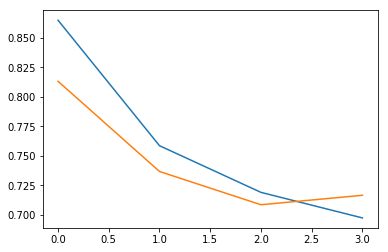

In [51]:
batch_size = 32
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name)

In [52]:
model_name = 'basic_seq2seq_20k_100_300d_1-1_LSTM'
model_file = model_name + '.h5'
# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

In [19]:
train_samples, test_samples = create_samples(data, max_seq_length=100, test_split=0.01)
print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Train samples: 157731
Test samples: 1594


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1170/1170 [==============================] - 1771s 2s/step - loss: 1.4571 - categorical_accuracy: 0.1212 - val_loss: 1.4295 - val_categorical_accuracy: 0.1212

Epoch 00001: val_loss improved from inf to 1.42950, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1170/1170 [==============================] - 1767s 2s/step - loss: 1.4005 - categorical_accuracy: 0.1268 - val_loss: 1.4137 - val_categorical_accuracy: 0.1240

Epoch 00002: val_loss improved from 1.42950 to 1.41367, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 3/5
1170/1170 [==============================] - 1764s 2s/step - loss: 1.3632 - categorical_accuracy: 0.1310 - val_loss: 1.3928 - val_categorical_accuracy: 0.1260

Epoch 00003: val_loss improved from 1.41367 to 1.39282, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 4/5
1170/1170 [==============================] - 1769s 2s/step - loss: 1.3340 - categorical_accuracy: 0.1343 - val_loss: 1.3804 - val_categorical_accuracy: 0.1279

Epoch 00004: val_loss improved from 1.39282 to 1.38038, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 5/5
1170/1170 [==============================] - 1764s 2s/step - loss: 1.3086 - categorical_accuracy: 0.1369 - val_loss: 1.3734 - val_categori

AttributeError: 'Line2D' object has no attribute 'setp'

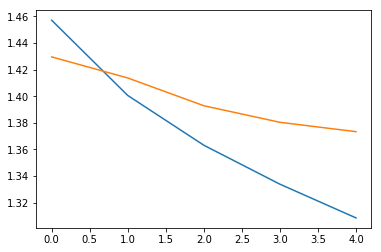

In [20]:
batch_size = 128
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name)

In [17]:
model_name = 'basic_seq2seq_20k_50_300d_1-1_LSTM'
model_file = model_name + '.h5'
# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

In [19]:
train_samples, test_samples = create_samples(data, max_seq_length=50, test_split=0.01)
print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Train samples: 157731
Test samples: 1594


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1170/1170 [==============================] - 1771s 2s/step - loss: 1.4571 - categorical_accuracy: 0.1212 - val_loss: 1.4295 - val_categorical_accuracy: 0.1212

Epoch 00001: val_loss improved from inf to 1.42950, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1170/1170 [==============================] - 1767s 2s/step - loss: 1.4005 - categorical_accuracy: 0.1268 - val_loss: 1.4137 - val_categorical_accuracy: 0.1240

Epoch 00002: val_loss improved from 1.42950 to 1.41367, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 3/5
1170/1170 [==============================] - 1764s 2s/step - loss: 1.3632 - categorical_accuracy: 0.1310 - val_loss: 1.3928 - val_categorical_accuracy: 0.1260

Epoch 00003: val_loss improved from 1.41367 to 1.39282, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 4/5
1170/1170 [==============================] - 1769s 2s/step - loss: 1.3340 - categorical_accuracy: 0.1343 - val_loss: 1.3804 - val_categorical_accuracy: 0.1279

Epoch 00004: val_loss improved from 1.39282 to 1.38038, saving model to basic_seq2seq_20k_200+50_300d_1-1_LSTM.h5
Epoch 5/5
1170/1170 [==============================] - 1764s 2s/step - loss: 1.3086 - categorical_accuracy: 0.1369 - val_loss: 1.3734 - val_categori

AttributeError: 'Line2D' object has no attribute 'setp'

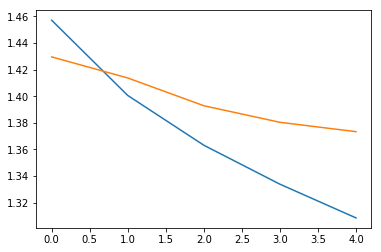

In [20]:
batch_size = 128
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name)

In [53]:
def prepare_input(input_text, tokenizer):
    return tokenizer.texts_to_sequences([preprocess(input_text)])[0]

def decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50):
    # Encode the input as state vectors.
    states_value = encinf.predict(input_seq)
    print('Sequence encoded')

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))  # time, features
    # Populate the first word with the eos index (.
    target_seq[0, 0] = eos_index
    
    decoder_inputs = [target_seq] + states_value

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    i = 1 # number of sampled words
    while not stop_condition:
        output, h, c = decinf.predict(decoder_inputs)
        sampled_word_index = np.argmax(output[0, -1, :])  # batch, time, features
        sampled_word = index_word[sampled_word_index]

        decoded_sentence += sampled_word + ' '
        # Exit condition: either hit max length or find stop character.
        if sampled_word == eos_token or i > max_output_len:
            stop_condition = True     

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_word_index
        i += 1
        
        # Update states
        decoder_inputs = [target_seq, h, c]

    return decoded_sentence

def beam_decoder_lstm(encinf, decinf, input_seq, k, vocab_size, max_output_len=50):
    # Encode the input as state vectors.
    states_value = encinf.predict(input_seq)
    print('Sequence encoded')

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))  # time, features
    # Populate the first word with the eos index.
    target_seq[0,0] = eos_index

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''    
    decoded_sequences = []
    
    # Init Beam Array
    beams = [(target_seq, states_value, 1.0)]
    
    output_len = 1 # number of sampled words
    while not stop_condition:        
        all_candidates = []
        for i in range(len(beams)):  # for each beam, try to append the next predicted word
            # Get the values of the beam
            target_seq, states_value, score = beams[i]
            
            # predict the next word and create candidate list
            output, h, c = decinf.predict([target_seq] + states_value)
            candidate_score_list = output[0][0]
            
            for j in range(len(candidate_score_list)):  # for each possible word, compute the score               
                # Add each candidate to the target sequence.
                candidate_seq = np.insert(target_seq, [1], j, axis=1)
                candidate_beam = [candidate_seq, [h, c],  score*-np.log(candidate_score_list[j])]
                all_candidates.append(candidate_beam)

        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[2], reverse=True)
        # select k best
        beams = ordered[:k]
        
        # if a beam has the index of the eos, 
        # 1. Add the beam to decoded_sequences, 
        # 2. Remove it from beams 
        # 3. Lower number of beams (k)
        for bindex, beam in enumerate(beams):
            if beam[0][0][-1] == eos_index:
                decoded_sequences.append(beam)
                del beams[bindex]
                k -= 1
                   
        # Exit condition: either each beam got eos or hit max length
        if len(beams) == 0 or output_len > max_output_len:
            # Add the beams that did not have eos so far to the decoded_sequences
            decoded_sequences += beams
            stop_condition = True 

        output_len += 1
        
    decoded_sentences = [' '.join([index_word[int(wi)-1] 
                                   for wi in seq[0]]) 
                         for seq, state, score in decoded_sequences]

    return decoded_sentences

In [56]:
test_line = """You find yourself in a dimly lit room. Before you you can spot a table. On the other side of the room
a poster hangs askew on the wall. examine poster."""
# test_line = """inventory"""
input_seq = prepare_input(test_line, tokenizer)

In [57]:
# model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, latent_dim=300, embedding_matrix=embedding_matrix,
#                              encoder_depth=1, decoder_depth=1, trainable_embeddings=False)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

# # load the 200-long model
# model_name = 'basic_seq2seq_20k_200_300d_1-1_LSTM'
# if os.path.isfile(model_name + '.h5'):
#     model.load_weights(model_name + '.h5')
#     encinf.load_weights(model_name + '-encinf.h5')
#     decinf.load_weights(model_name + '-decinf.h5')
decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50)

Sequence encoded


'you are in a small clearing in a well marked forest path that extends to the east and south behind the house is a path leading down a path leads northwest and a path leads southeast and a path leads southeast and a passage leads southeast a small passage leads southeast '

In [26]:
beam_decoder_lstm(encinf, decinf, input_seq, 2, vocab_size, max_output_len=50)

Sequence encoded


['UNK chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly sirens sirens sirens sirens chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly sirens sirens sirens sirens chilly chilly chilly chilly chilly',
 'UNK chilly never chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly sirens sirens sirens sirens chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly chilly sirens sirens sirens sirens chilly chilly chilly chilly chilly']